In [4]:
printmd('Neural Network Diabetic Retinopathy Detector')
printmd('Using Demo Mirrored Distribution Stratagy')
printmd('Data Augmentation, Data Balancing, Data Statistics and Class Samples plotting')
printmd('Early Stopping, Reduce Learning Rate on Plateau, Checkpoints')
printmd(' ')
printmd('Contains One self designed CNN Model and 4 Pre-trained CNN Models') 
printmd('Pre-trained Models are InceptionResNetV2, DenseNet121, ResNet50V2 and Xception')
printmd('All Models trained for 250 Epochs. Performances of all Models are as below')
printmd(' ')
printmd('Self Designed Model accuracy-----------: 92.30%')
printmd('InceptionResNetv2 Model accuracy----: 88.90%')
printmd('DenseNet121 Model accuracy------------: 79.20%')
printmd('ResNet50V2 Model accuracy-------------: 93.16%')
printmd('Xception Model accuracy------------------: 83.47%')

## <span style="color:#111155">Neural Network Diabetic Retinopathy Detector</span>

## <span style="color:#111155">Using Demo Mirrored Distribution Stratagy</span>

## <span style="color:#111155">Data Augmentation, Data Balancing, Data Statistics and Class Samples plotting</span>

## <span style="color:#111155">Early Stopping, Reduce Learning Rate on Plateau, Checkpoints</span>

## <span style="color:#111155"> </span>

## <span style="color:#111155">Contains One self designed CNN Model and 4 Pre-trained CNN Models</span>

## <span style="color:#111155">Pre-trained Models are InceptionResNetV2, DenseNet121, ResNet50V2 and Xception</span>

## <span style="color:#111155">All Models trained for 250 Epochs. Performances of all Models are as below</span>

## <span style="color:#111155"> </span>

## <span style="color:#111155">Self Designed Model accuracy-----------: 92.30%</span>

## <span style="color:#111155">InceptionResNetv2 Model accuracy----: 88.90%</span>

## <span style="color:#111155">DenseNet121 Model accuracy------------: 79.20%</span>

## <span style="color:#111155">ResNet50V2 Model accuracy-------------: 93.16%</span>

## <span style="color:#111155">Xception Model accuracy------------------: 83.47%</span>

In [2]:
################################################################################################################################
# Import all modules including Pre-trained, callback, Early-stopping and other deep learning modules
################################################################################################################################
import time
start = time.time()
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import tensorflow_addons as tfa
import tqdm
################################################################################################################################
# Importing Callback modules
################################################################################################################################
tqdm_callback = tfa.callbacks.TQDMProgressBar()
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
################################################################################################################################
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from tensorflow.keras.models import load_model   
import time
import os
import subprocess
from tensorflow.keras import Model
################################################################################################################################
# Importing Pre-trained models
################################################################################################################################
from tensorflow.keras.applications import InceptionResNetV2, ResNet50V2, DenseNet121, Xception
################################################################################################################################


from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('## <span style="color:#111155">'+string+'</span>'))

In [4]:
################################################################################################################################
# define the target size of the images
################################################################################################################################

H,W=350,350

In [5]:
################################################################################################################################
# Define Train ImagedataGenerator with required Augmentation properties
################################################################################################################################

train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   featurewise_center=True,
                                   featurewise_std_normalization=True,
                                   rotation_range=360,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True)                                  

In [6]:
################################################################################################################################
# Define Test ImagedataGenerator with just rescale property 
################################################################################################################################
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
################################################################################################################################
# read the training labels file
################################################################################################################################

train = pd.read_csv('./datasets/trainLabels.csv')

print('Total Number of samples: ', train.shape[0])

Total Number of samples:  1427


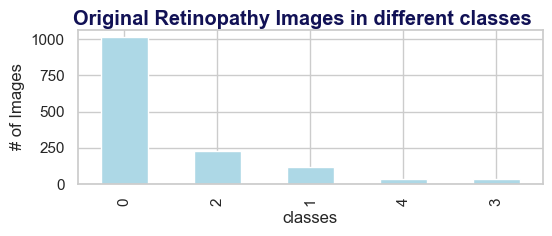

In [8]:
################################################################################################################################
# Verify the labels are evenly distributed or not
################################################################################################################################
plt.figure(figsize=(6,2))
Vcounts = train['level'].value_counts().plot(kind='bar',color='lightblue')
plt.xlabel('classes')
plt.ylabel('# of Images')
plt.suptitle('Original Retinopathy Images in different classes',color='#111155',fontweight='bold')
plt.show()

In [9]:
train.image.describe()

count        1427
unique       1427
top       84_left
freq            1
Name: image, dtype: object

In [10]:
printmd('Data is highly imbalanced; class 0 is abundant and rest are rare. Need to balance.')

## <span style="color:#111155">Data is highly imbalanced; class 0 is abundant and rest are rare. Need to balance.</span>

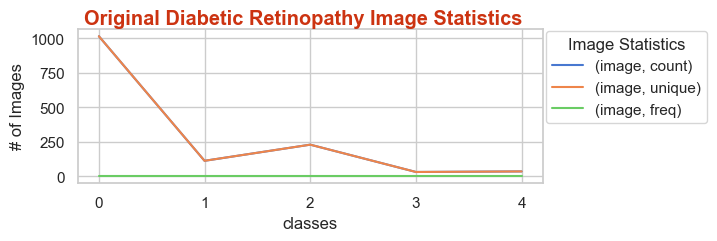

In [11]:
################################################################################################################################
# Image statistics before balancing.
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
train.groupby(by='level').describe().plot(kind='line',figsize=(6,2)) 
plt.xticks(range(5))
plt.legend(title='Image Statistics', bbox_to_anchor=(.870, .54, 0.5, 0.5))                                                   
plt.xlabel('classes')
plt.ylabel('# of Images')
plt.suptitle('Original Diabetic Retinopathy Image Statistics',color='#cc3311',fontweight='bold')
plt.show() 

In [12]:
################################################################################################################################
# Read the modified - balanced training labels file - I manually created this file as there is no proper sampling module
# that fitted my requirement.
################################################################################################################################

train = pd.read_csv('./datasets/Train1.csv')


print('Total Number of samples: ', train.shape[0])

Total Number of samples:  1402


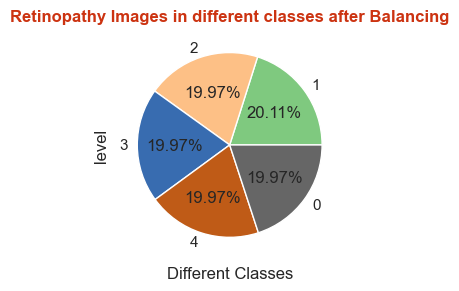

In [13]:
################################################################################################################################
# verify the labels in the modified - balanced labels file
################################################################################################################################
plt.figure(figsize=(6,3))
Vcounts = train['level'].value_counts().plot(kind='pie',autopct='%.2f%%',colormap='Accent')
plt.xlabel('Different Classes')
plt.title('Retinopathy Images in different classes after Balancing',color='#cc3311',fontweight='bold')
plt.show()

In [14]:
train.image.describe()

count         1402
unique         691
top       932_left
freq             9
Name: image, dtype: object

In [15]:
printmd('Data is fully balanced now.')

## <span style="color:#111155">Data is fully balanced now.</span>

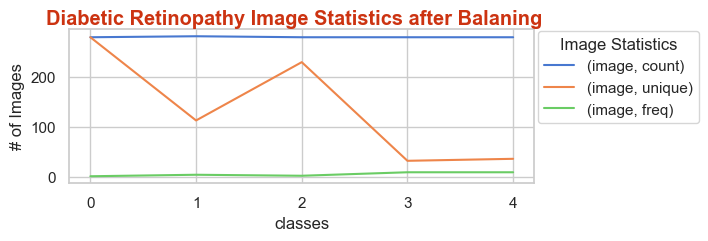

In [16]:
################################################################################################################################
# Image statistics after balancing.
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
train.groupby(by='level').describe().plot(kind='line',figsize=(6,2)) 
plt.legend(title='Image Statistics', bbox_to_anchor=(.87, .54, 0.5, 0.5))
plt.xticks(range(5))
plt.xlabel('classes')
plt.ylabel('# of Images')
plt.suptitle('Diabetic Retinopathy Image Statistics after Balaning',color='#cc3311',fontweight='bold')
plt.show() 

In [17]:
################################################################################################################################
# modify the train labels file by appending the file extensions to the file names. Display the top 5 rows.
################################################################################################################################

train["image"] = train["image"].apply(lambda x: x + ".jpeg")
train['level'] = train['level'].astype('str')
display(train.head())

,image,level
0,844_right.jpeg,1
1,869_left.jpeg,1
2,869_right.jpeg,1
3,971_right.jpeg,1
4,978_left.jpeg,1


In [18]:
################################################################################################################################
# verify the number of classes in the trainlabels file and assign the number to a Classes variable. 
################################################################################################################################

Classes = train['level'].nunique()
Classes

5

In [19]:
################################################################################################################################
# split the labels into train and test labels by 75% ,25% ratio, and also stratify to make sure all classes evenly distributed.
################################################################################################################################

X_train, X_test = train_test_split(train, train_size=0.75, random_state=2,stratify=train['level'])

In [20]:
################################################################################################################################
# check the shapes of train and test lables file
################################################################################################################################
X_train.shape, X_test.shape

((1051, 2), (351, 2))

In [21]:
################################################################################################################################
# creat the train data file using train labels file and the images file
################################################################################################################################

trainDF = train_datagen.flow_from_dataframe(
                        dataframe=X_train,
                        directory="./datasets/dataset",
                        x_col="image",
                        y_col="level",
                        class_mode="categorical",
                        batch_size=8,
                        target_size=(H, W),
                        seed=0)

Found 1048 validated image filenames belonging to 5 classes.


In [22]:
################################################################################################################################
# create the test data file using test labels file and images file
################################################################################################################################

testDF = test_datagen.flow_from_dataframe(
                        dataframe=X_test,
                        directory="./datasets/dataset",
                        x_col="image",
                        y_col="level",
                        class_mode="categorical",
                        batch_size=8,
                        target_size=(H, W),
                        seed=0)

Found 351 validated image filenames belonging to 5 classes.


In [23]:
################################################################################################################################
# look at the first 10 records in either test or train data file to make sure file names are propely created and loaded
################################################################################################################################

testDF.filenames[0:10]

['9200_left.jpeg',
 '9324_left.jpeg',
 '9157_right.jpeg',
 '99_right.jpeg',
 '9949_right.jpeg',
 '9868_right.jpeg',
 '9298_left.jpeg',
 '9366_left.jpeg',
 '9951_left.jpeg',
 '8449_right.jpeg']

In [24]:
################################################################################################################################
# look at the top 10 lables in either the test or train data file to make sure they are properly loaded 
################################################################################################################################

testDF.classes[0:10]

[2, 2, 4, 3, 1, 1, 4, 1, 3, 0]

In [25]:
################################################################################################################################
# verify the class counts in train data file
################################################################################################################################

trainDF.classes.count(0),trainDF.classes.count(1),trainDF.classes.count(2),trainDF.classes.count(3),trainDF.classes.count(4)

(210, 208, 210, 210, 210)

In [26]:
################################################################################################################################
# verify the test data file class counts
################################################################################################################################

testDF.classes.count(0),testDF.classes.count(1),testDF.classes.count(2),testDF.classes.count(3),testDF.classes.count(4)

(70, 71, 70, 70, 70)

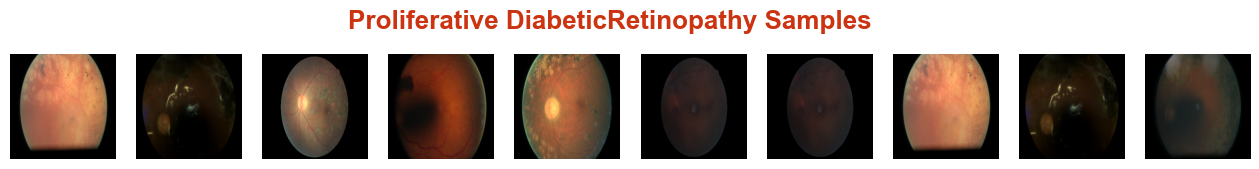

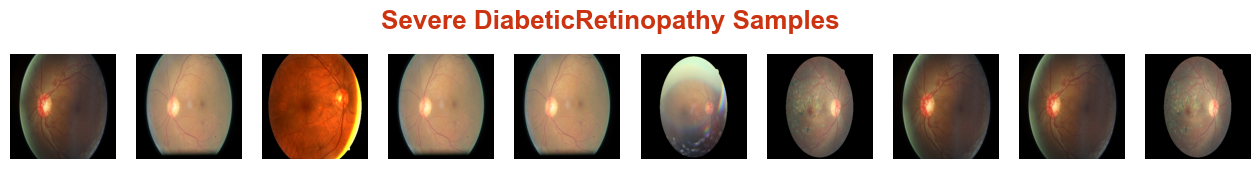

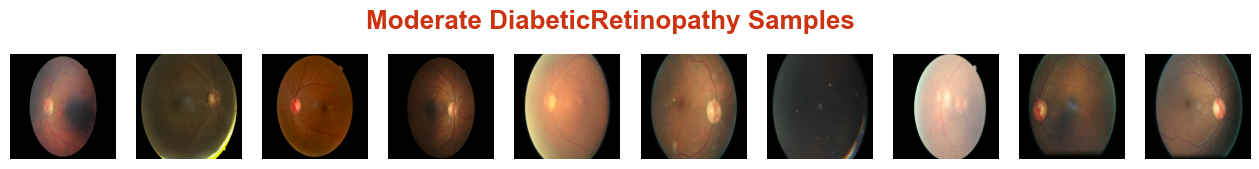

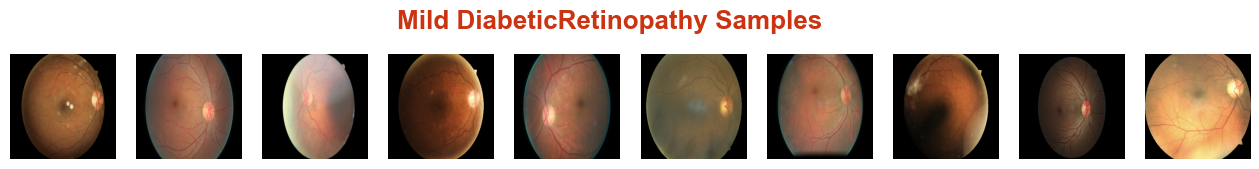

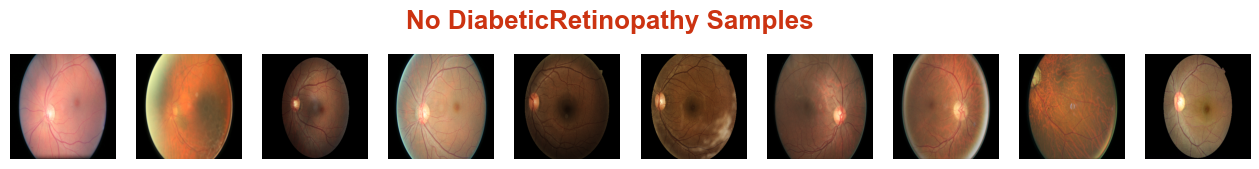

In [27]:
################################################################################################################################
# display 10 images from all the 5 classes
################################################################################################################################
n_explain = 10
testDF.batch_size = 1 
sns.set(style='whitegrid', palette='muted', font_scale=1.3)
plt.figure(figsize=(16, 2))
a=0
for i in range(X_test.shape[0]+1):
    image, label = next(testDF) 
    if np.argmax(label) == 4 and a<n_explain:
        a+=1
        plt.subplot(1, n_explain, a)
        image=image.reshape(H,W,3)
        plt.imshow(image)
        plt.axis('off')
    if a == n_explain:
        plt.suptitle("Proliferative DiabeticRetinopathy Samples",color='#cc3311',fontweight='bold')
        plt.show()
        break
plt.figure(figsize=(16, 2))
a=0
for i in range(X_test.shape[0]+1):
    image, label = next(testDF) 
    if np.argmax(label) == 3 and a<n_explain:
        a+=1
        plt.subplot(1, n_explain, a)
        image=image.reshape(H,W,3)
        plt.imshow(image)
        plt.axis('off')
    if a == n_explain:
        plt.suptitle("Severe DiabeticRetinopathy Samples",color='#cc3311',fontweight='bold')
        plt.show()
        break
plt.figure(figsize=(16, 2))
a=0
for i in range(X_test.shape[0]+1):
    image, label = next(testDF) 
    if np.argmax(label) == 2 and a<n_explain:
        a+=1
        plt.subplot(1, n_explain, a)
        image=image.reshape(H,W,3)
        plt.imshow(image)
        plt.axis('off')
    if a == n_explain:
        plt.suptitle("Moderate DiabeticRetinopathy Samples",color='#cc3311',fontweight='bold')
        plt.show()
        break
plt.figure(figsize=(16, 2))
a=0
for i in range(X_test.shape[0]+1):
    image, label = next(testDF) 
    if np.argmax(label) == 1 and a<n_explain:
        a+=1
        plt.subplot(1, n_explain, a)
        image=image.reshape(H,W,3)
        plt.imshow(image)
        plt.axis('off')
    if a == n_explain:
        plt.suptitle("Mild DiabeticRetinopathy Samples",color='#cc3311',fontweight='bold')
        plt.show()
        break
plt.figure(figsize=(16, 2))
a=0
for i in range(X_test.shape[0]+1):
    image, label = next(testDF) 
    if np.argmax(label) == 0 and a<n_explain:
        a+=1
        plt.subplot(1, n_explain, a)
        image=image.reshape(H,W,3)
        plt.imshow(image)
        plt.axis('off')
    if a == n_explain:
        plt.suptitle("No DiabeticRetinopathy Samples",color='#cc3311',fontweight='bold')
        plt.show()
        break

In [28]:
printmd('Creating Demo Mirrored Distributed Strategy with CPU and GPU')

## <span style="color:#111155">Creating Demo Mirrored Distributed Strategy with CPU and GPU</span>

In [29]:
################################################################################################################################
# Creating Mirrored Distributed stratagy
################################################################################################################################
strategy = tf.distribute.MirroredStrategy(['cpu:0','gpu:0'])  
print('Number of devices: {}'.format(strategy.num_replicas_in_sync)) 

batch_size_per_replica = 8
global_batch_size = batch_size_per_replica * strategy.num_replicas_in_sync
EPOCHS = 200
print('global_batch_size:',global_batch_size)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:GPU:0')
Number of devices: 2
global_batch_size: 16


In [30]:
with strategy.scope():
    options=tf.data.Options()
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA

In [31]:
printmd('Defining CNN Model with 17 layers') 
printmd('6 each of Conv2d and Maxpooling, 2 Dense and one each of BatchNorm, Dropout and Flatten') 
printmd('Total 925,637 parameters')

## <span style="color:#111155">Defining CNN Model with 17 layers</span>

## <span style="color:#111155">6 each of Conv2d and Maxpooling, 2 Dense and one each of BatchNorm, Dropout and Flatten</span>

## <span style="color:#111155">Total 925,637 parameters</span>

In [32]:
################################################################################################################################
# Defining CNN model 
################################################################################################################################
def create_model():
    model = tf.keras.Sequential([
         tf.keras.layers.Input(shape=(W,H,3)),
         tf.keras.layers.Conv2D(64, 3, activation=tf.nn.relu),
         tf.keras.layers.MaxPooling2D(),
         tf.keras.layers.Conv2D(128, 3, activation=tf.nn.relu),
         tf.keras.layers.BatchNormalization(),
         tf.keras.layers.MaxPooling2D(),
         tf.keras.layers.Conv2D(100, 3, activation=tf.nn.relu),
         tf.keras.layers.MaxPooling2D(),
         tf.keras.layers.Conv2D(100, 3, activation=tf.nn.relu,activity_regularizer=tf.keras.regularizers.l1(0.000001)),
         tf.keras.layers.MaxPooling2D(),
         tf.keras.layers.Conv2D(100, 3, activation=tf.nn.relu,activity_regularizer=tf.keras.regularizers.l2(0.000001)),
         tf.keras.layers.MaxPooling2D(),
         tf.keras.layers.Conv2D(100, 3, activation=tf.nn.relu),
         tf.keras.layers.MaxPooling2D(),
         tf.keras.layers.Flatten(),
         tf.keras.layers.Dense(512, activation=tf.nn.relu, activity_regularizer = tf.keras.regularizers.l2(0.000001)),
         tf.keras.layers.Dropout(.5),
         tf.keras.layers.Dense(5, activation=tf.nn.softmax, activity_regularizer = tf.keras.regularizers.l1(0.000001))          
  ])
    return model

In [33]:
################################################################################################################################
# Defining the loss criteria 
################################################################################################################################
with strategy.scope():
   
  loss_obj = tf.keras.losses.CategoricalCrossentropy(from_logits = True,reduction = tf.keras.losses.Reduction.AUTO)
     

In [34]:
################################################################################################################################
# Defining Categorical Accuracy as metrics to monitor 
################################################################################################################################
with strategy.scope():
    accu = tf.keras.metrics.CategoricalAccuracy(name='accuracy')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [35]:
################################################################################################################################
# Defining variables such as paitience for Early Stopping, Reduce learning rate on plateau patience number, Learning rate Decay
# drop percentage, File path to store the best parameters at check point, EPOCHS and learning rate
################################################################################################################################
WORKERS=1
EPOCHS=200
ES_PATIENCE = 6
RLROP_PAT = 3
DECAY_DROP = .95
lr=0.0000002

FILEPATHA="./Weights/weights_DRTD_MyCNN_Model_best_92_3%.hdf5"

In [36]:
################################################################################################################################
# Instantiating the model, defining the Optimizer as Adam, lr as 0.0000002,Check point criteria, check point parameters,
# Early Stopping, Reduce learning rate on plateau with Learning rate Decay drop, to what min lr to drop  and callback list.
################################################################################################################################

with strategy.scope():
  # create model, optimizer,callbacks and checkpoints 
  model = create_model()
  optimizer  = tf.keras.optimizers.Adam(lr=lr, beta_1=0.9)
  checkpoint = ModelCheckpoint(FILEPATHA, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  Early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
  Reduce_lr_on_plat=ReduceLROnPlateau(monitor='val_accuracy',mode='auto',patience=RLROP_PAT,factor=DECAY_DROP,\
                                    min_lr=1e-15,verbose=2)

  callback_list = [tqdm_callback, checkpoint, Early_stop, Reduce_lr_on_plat] 
  callbacks=callback_list  


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [37]:
################################################################################################################################
# Compiling the model with Adam optimizer, learning rate .0002, loss Categorical crossentropy and eval metrics as Accuracy
################################################################################################################################
with strategy.scope():
    model.compile(optimizer=optimizer, loss = loss_obj,metrics = [accu])
    

In [38]:
################################################################################################################################
# Reassign the batch sizes to train and test files
################################################################################################################################

testDF.batch_size = 8     
trainDF.batch_size = 8


In [41]:
################################################################################################################################
# loading my trained CNN model-trained for 300 epochs with Adam lr=0.000002,loss= categorical_crossentropy and E metric accuracy
# and also compiling and printing my model architecture to prove this is my CNN model and not something else.
################################################################################################################################
with strategy.scope():
    
    model = load_model(FILEPATHA)
    model.compile(optimizer=optimizer, loss = loss_obj,metrics = [accu]) 

    model.summary()                                                                                                     

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 348, 348, 64)      1792      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 174, 174, 64)      0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 172, 172, 128)     73856     
_________________________________________________________________
batch_normalization_38 (Batc (None, 172, 172, 128)     512       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 86, 86, 128)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 84, 84, 100)       115300    
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 42, 42, 100)     

In [42]:
################################################################################################################################
# Verify that the distributed strategy has been picked by the loaded model 
################################################################################################################################
model.distribute_strategy

In [43]:
################################################################################################################################
# fit the model with train dataset and compute mean loss and mean accuracy across all instances/devices for each epoch 
################################################################################################################################
with strategy.scope():
    history= strategy.reduce('MEAN',model.fit_generator(trainDF,validation_data = testDF,epochs=5,\
                                                        verbose=0,shuffle=True,callbacks=callbacks,workers=WORKERS),axis=None)

Training:   0%|                                                                                 0/5 ETA: ?s,  …

Epoch 1/5


0/131                                                                                                        E…

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:0').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:

0/131                                                                                                        E…


Epoch 00002: val_accuracy improved from 0.92023 to 0.92308, saving model to ./Weights\weights_DRTD_MyCNN_Model_best_92_3%.hdf5
Epoch 3/5


0/131                                                                                                        E…


Epoch 00003: val_accuracy did not improve from 0.92308
Epoch 4/5


0/131                                                                                                        E…


Epoch 00004: val_accuracy did not improve from 0.92308
Epoch 5/5


0/131                                                                                                        E…


Epoch 00005: val_accuracy did not improve from 0.92308

Epoch 00005: ReduceLROnPlateau reducing learning rate to 1.900000022203585e-07.


In [42]:
################################################################################################################################
# evalute with train dataset and test dataset and compute mean loss and mean accuracy from across all devices 
################################################################################################################################
with strategy.scope():
    train_loss, train_acc = strategy.reduce('MEAN',model.evaluate(trainDF, batch_size=8, verbose=0,\
                                                                  callbacks=[tqdm_callback]),axis=None)
    test_loss, test_acc = strategy.reduce('MEAN',model.evaluate(testDF,batch_size=8, verbose=0,\
                                                                callbacks=[tqdm_callback]),axis=None)

    print('Train Accu: %.3f, Test Accu: %.3f' % (train_acc, test_acc))
    print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss, test_loss))

0/131                                                                                              ETA: ?s - E…

0/44                                                                                               ETA: ?s - E…

Train Accu: 0.916, Test Accu: 0.920
Train Loss: 0.263, Test Loss: 0.297


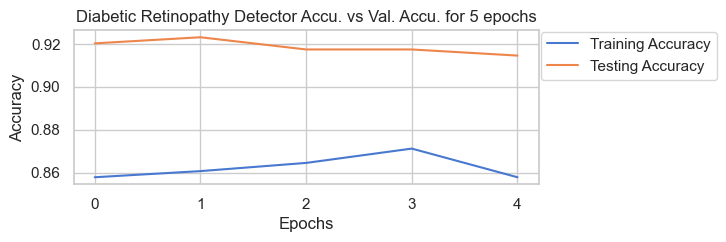

In [45]:
################################################################################################################################
# plot the training and validation accuracy of the 5 epochs
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
plt.figure(figsize=(6,2))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.xticks(range(5))
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Diabetic Retinopathy Detector Accu. vs Val. Accu. for 5 epochs')
plt.grid(True)
plt.legend( bbox_to_anchor=(0.9, .54, 0.5, 0.5))
plt.show()

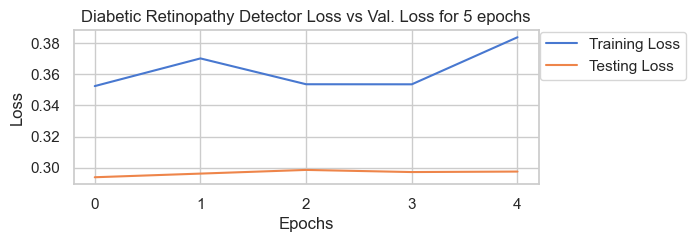

In [46]:
################################################################################################################################
# plot the training and validation loss of the 5 epochs
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
plt.figure(figsize=(6,2))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.xticks(range(5))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Diabetic Retinopathy Detector Loss vs Val. Loss for 5 epochs')
plt.grid(True)
plt.legend( bbox_to_anchor=(0.834, .54, 0.5, 0.5))

plt.show()

In [43]:
################################################################################################################################
# predict using the model on training and testing data files, and compute data for confusion matix, class. report and AUC/ROC
################################################################################################################################
Test_size = testDF.n//testDF.batch_size
# Create empty arays to keep the predictions and labels
Test_Pred = np.empty((0, Classes))
Test_Labels = np.empty((0, Classes))

# Add test predictions and labels
for i in range(Test_size+1):
    image, label = next(testDF)
    scores = model.predict(image, batch_size=testDF.batch_size)
    Test_Pred = np.append(Test_Pred, scores, axis=0)
    Test_Labels = np.append(Test_Labels, label, axis=0)

total_test_preds  = [np.argmax(pred)  for pred  in Test_Pred]
total_test_labels = [np.argmax(label) for label in Test_Labels]
test_cnfu_matrix = confusion_matrix(total_test_labels, total_test_preds)
labels = ['0-No DR', '1-Mild DR', '2-Mod. DR', '3-Severe DR', '4-Prolif. DR']
test_df_cm  = pd.DataFrame(test_cnfu_matrix,  index=labels, columns=labels)
print(test_df_cm)

              0-No DR  1-Mild DR  2-Mod. DR  3-Severe DR  4-Prolif. DR
0-No DR            51         11          2            2             0
1-Mild DR           1         71          0            1             0
2-Mod. DR           0          9         57            0             1
3-Severe DR         0          0          0           68             0
4-Prolif. DR        0          0          0            0            72


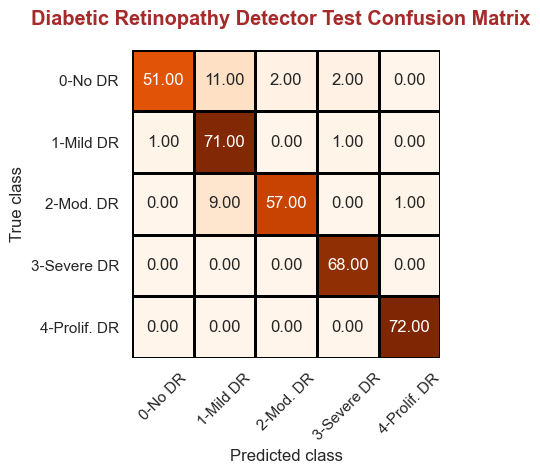

(70, 71, 70, 70, 70)

In [44]:
################################################################################################################################
# plot the confusion matrix of training and testing predictions and also print the traing classes counts 
################################################################################################################################
plt.figure(figsize=(4,4))
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
sns.heatmap(test_df_cm,annot=True,fmt='.2f',linewidths=2,linecolor='black',square=True,cmap=plt.cm.Oranges,\
            cbar=False)
plt.suptitle('Diabetic Retinopathy Detector Test Confusion Matrix',color='brown',fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()  
testDF.classes.count(0),testDF.classes.count(1),testDF.classes.count(2),testDF.classes.count(3),testDF.classes.count(4)

In [45]:
################################################################################################################################
# print the classification report with precision, recall and f1-score for my CNN Model
################################################################################################################################

tnames=['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
print(classification_report(total_test_labels, total_test_preds,target_names=tnames))

                  precision    recall  f1-score   support

           No DR       0.98      0.77      0.86        66
         Mild DR       0.78      0.97      0.87        73
     Moderate DR       0.97      0.85      0.90        67
       Severe DR       0.96      1.00      0.98        68
Proliferative DR       0.99      1.00      0.99        72

        accuracy                           0.92       346
       macro avg       0.93      0.92      0.92       346
    weighted avg       0.93      0.92      0.92       346



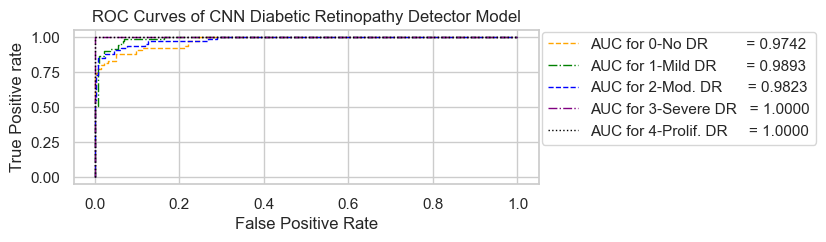

In [46]:
################################################################################################################################
# plot the roc_curve and print the AUC values in it for all the 5 classes of my CNN model.
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_classes = 5
i=0
while i < n_classes:
    fpr[i], tpr[i], thresh[i] = roc_curve(Test_Labels[:,i], Test_Pred[:,i])
    i+=1

i=0
while i < n_classes:
    roc_auc[i] = auc(fpr[i], tpr[i])
    i+=1

plt.figure(figsize=(6,2))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange',lw=1, label='AUC for 0-No DR         = %0.4f'% roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='-.',color='green', lw=1, label='AUC for 1-Mild DR       = %0.4f'% roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue',  lw=1, label='AUC for 2-Mod. DR      = %0.4f'% roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='-.',color='purple',lw=1, label='AUC for 3-Severe DR   = %0.4f'% roc_auc[3])
plt.plot(fpr[4], tpr[4], linestyle=':', color='black', lw=1, label='AUC for 4-Prolif. DR     = %0.4f'% roc_auc[4])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curves of CNN Diabetic Retinopathy Detector Model') 
plt.grid(True)
plt.legend(loc='best', bbox_to_anchor=(0.99, .54, 0.5, 0.5))
plt.show()


In [47]:
printmd('Model saving and loading using Tensorflow-serving')

## <span style="color:#111155">Model saving and loading using Tensorflow-serving</span>

In [48]:
################################################################################################################################
# prpare to save the model using tensorflow-serving. Define the path and version
################################################################################################################################

MODEL_DIR = os.getcwd()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path =\n {}\n'.format(export_path))

export_path =
 C:\Users\Dayakar Malgari\LEARN\PROJECTS\1



In [49]:
################################################################################################################################
# Saving the model in my directory 
################################################################################################################################
with strategy.scope():
    tf.keras.models.save_model(
        model,
        export_path,
        overwrite=True,
        include_optimizer=True,
        save_format=None
    )

INFO:tensorflow:Assets written to: C:\Users\Dayakar Malgari\LEARN\PROJECTS\1\assets


In [50]:
################################################################################################################################
# Loading the saved model from my directory
################################################################################################################################
with strategy.scope():
    model= ' '
    model= tf.keras.models.load_model('./1/') #saved_model.pb
    model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 348, 348, 64)      1792      
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 174, 174, 64)      0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 172, 172, 128)     73856     
_________________________________________________________________
batch_normalization_38 (Batc (None, 172, 172, 128)     512       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 86, 86, 128)       0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 84, 84, 100)       115300    
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 42, 42, 100)     

In [51]:
################################################################################################################################
# Evaluate the model after reloading verify the training and testing accuracy and losses without startegy.
################################################################################################################################

train_loss, train_acc = model.evaluate(trainDF, batch_size=8, verbose=0,callbacks=[tqdm_callback])
test_loss, test_acc = model.evaluate(testDF,  batch_size=8, verbose=0,callbacks=[tqdm_callback])
print('Train Accu: %.3f, Test Accu: %.3f' % (train_acc, test_acc))
print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss, test_loss))

0/131                                                                                              ETA: ?s - E…

0/44                                                                                               ETA: ?s - E…

Train Accu: 0.907, Test Accu: 0.920
Train Loss: 0.249, Test Loss: 0.297


In [56]:
printmd('Self Designed CNN Model has the accuracy of 92.30%')

## <span style="color:#111155">Self Designed CNN Model has the accuracy of 92.30%</span>

In [57]:
printmd('Below are 4 Pre-trained Models and their evaluations;') 
printmd('Models are InceptionResNetV2, DenseNet121, ResNet50V2 and Xception')

## <span style="color:#111155">Below are 4 Pre-trained Models and their evaluations;</span>

## <span style="color:#111155">Models are InceptionResNetV2, DenseNet121, ResNet50V2 and Xception</span>

In [58]:
printmd('InceptionResNetV2 Model evaluation and prediction now ')

## <span style="color:#111155">InceptionResNetV2 Model evaluation and prediction now </span>

In [54]:
################################################################################################################################
###############################  Loading the trained InceptionResNetV2 model       #############################################
################################################################################################################################
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
input_shape=(W,H,3)
input_tensor = tf.keras.layers.Input(shape=input_shape)

model = InceptionResNetV2(weights='imagenet',input_shape=(W,H,3),input_tensor=input_tensor,include_top=False)
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1536, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
out = tf.keras.layers.Dense(5,activation='softmax',activity_regularizer = tf.keras.regularizers.l2(0.000001))(x)
model = Model(input_tensor, out)
for layer in model.layers:
    layer.trainable = False

for i in range(-3, 0):
    model.layers[i].trainable = True



FILEPATHA="./Weights/weights_DRTD_InceptionResNetV2.hdf5"



model = load_model(FILEPATHA)
checkpointA = ModelCheckpoint(FILEPATHA, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
Early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
Reduce_lr_on_plat=ReduceLROnPlateau(monitor='val_accuracy',mode='auto',patience=RLROP_PAT,factor=DECAY_DROP,\
                                    min_lr=1e-15,verbose=2)

callback_list = [tqdm_callback, checkpointA, Early_stop, Reduce_lr_on_plat]  
model.compile(optimizer=Adam(lr=0.0000002, beta_1=0.9), loss='categorical_crossentropy',  metrics=["accuracy"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 350, 350, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 174, 174, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 174, 174, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 174, 174, 32) 0           batch_normalization_203[0][0]    
____________________________________________________________________________________________

In [60]:
################################################################################################################################
# fit the InceptionResNetV2 Model just for 5 epochs to show the accuracy and loss values for training and testing
################################################################################################################################

history = model.fit_generator(generator=trainDF,validation_data=testDF,epochs=5, callbacks=callback_list,verbose=0)

Training:   0%|                                                                                 0/5 ETA: ?s,  …

Epoch 1/5


0/131                                                                                                        E…


Epoch 00001: val_accuracy improved from -inf to 0.88889, saving model to ./Weights\weights_DRTD_InceptionResNetV2.hdf5
Epoch 2/5


0/131                                                                                                        E…


Epoch 00002: val_accuracy did not improve from 0.88889
Epoch 3/5


0/131                                                                                                        E…


Epoch 00003: val_accuracy did not improve from 0.88889
Epoch 4/5


0/131                                                                                                        E…


Epoch 00004: val_accuracy did not improve from 0.88889

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.900000022203585e-07.
Epoch 5/5


0/131                                                                                                        E…


Epoch 00005: val_accuracy did not improve from 0.88889


In [61]:
################################################################################################################################
# evaluate the InceptionResNetV2 Model on train and test datasets
################################################################################################################################
train_loss, train_acc = model.evaluate(trainDF, batch_size=8, verbose=0,callbacks=[tqdm_callback])
test_loss, test_acc = model.evaluate(testDF,  batch_size=8, verbose=0,callbacks=[tqdm_callback])
print('Train Accu: %.3f, Test Accu: %.3f' % (train_acc, test_acc))
print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss, test_loss))

0/131                                                                                              ETA: ?s - E…

0/44                                                                                               ETA: ?s - E…

Train Accu: 0.859, Test Accu: 0.889
Train Loss: 0.367, Test Loss: 0.331


In [62]:
################################################################################################################################
# predict using the model on training and testing data files, and compute data for confusion matix, class. report and AUC/ROC
################################################################################################################################
Test_size = testDF.n//testDF.batch_size
# Create empty arays to keep the predictions and labels
Test_Pred = np.empty((0, Classes))
Test_Labels = np.empty((0, Classes))

# Add test predictions and labels
for i in range(Test_size+1):
    image, label = next(testDF)
    scores = model.predict(image, batch_size=testDF.batch_size)
    Test_Pred = np.append(Test_Pred, scores, axis=0)
    Test_Labels = np.append(Test_Labels, label, axis=0)

total_test_preds  = [np.argmax(pred)  for pred  in Test_Pred]
total_test_labels = [np.argmax(label) for label in Test_Labels]
test_cnfu_matrix = confusion_matrix(total_test_labels, total_test_preds)
labels = ['0-No DR', '1-Mild DR', '2-Mod. DR', '3-Severe DR', '4-Prolif. DR']
test_df_cm  = pd.DataFrame(test_cnfu_matrix,  index=labels, columns=labels)
print(test_df_cm)

              0-No DR  1-Mild DR  2-Mod. DR  3-Severe DR  4-Prolif. DR
0-No DR            60          4          5            2             0
1-Mild DR           7         60          0            1             0
2-Mod. DR          11          3         54            3             0
3-Severe DR         0          0          0           73             0
4-Prolif. DR        0          0          2            0            66


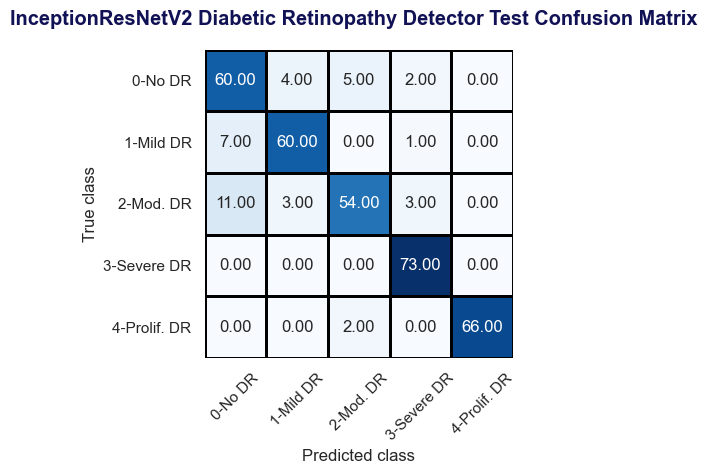

(70, 71, 70, 70, 70)

In [63]:
################################################################################################################################
# plot the confusion matrix of training and testing predictions and also print the traing classes counts 
################################################################################################################################
plt.figure(figsize=(4,4))
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
sns.heatmap(test_df_cm,annot=True,fmt='.2f',linewidths=2,linecolor='black',square=True,cmap=plt.cm.Blues,\
            cbar=False)
plt.suptitle('InceptionResNetV2 Diabetic Retinopathy Detector Test Confusion Matrix',color='#111155',fontweight='bold')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()  
testDF.classes.count(0),testDF.classes.count(1),testDF.classes.count(2),testDF.classes.count(3),testDF.classes.count(4)

In [64]:
################################################################################################################################
# print the classification report giving precision, recall, f-1 score and accuracy of the pretrained InceptionResNetV2 Model
################################################################################################################################
tnames=['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
print(classification_report(total_test_labels, total_test_preds,target_names=tnames))

                  precision    recall  f1-score   support

           No DR       0.77      0.85      0.81        71
         Mild DR       0.90      0.88      0.89        68
     Moderate DR       0.89      0.76      0.82        71
       Severe DR       0.92      1.00      0.96        73
Proliferative DR       1.00      0.97      0.99        68

        accuracy                           0.89       351
       macro avg       0.89      0.89      0.89       351
    weighted avg       0.89      0.89      0.89       351



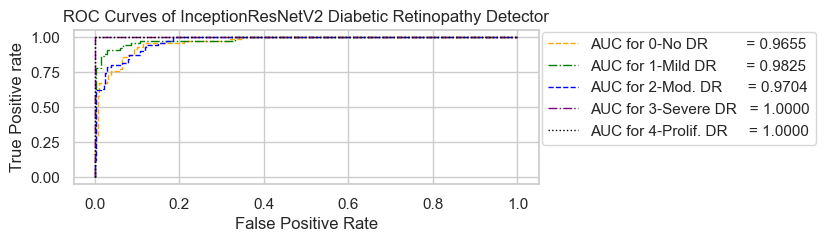

In [65]:
################################################################################################################################
# plot the roc_curve and print the AUC values in it for all the 5 classes of InceptionResNetV2 Model.
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)

fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_classes = 5
i=0
while i < n_classes:
    fpr[i], tpr[i], thresh[i] = roc_curve(Test_Labels[:,i], Test_Pred[:,i])
    i+=1

i=0
while i < n_classes:
    roc_auc[i] = auc(fpr[i], tpr[i])
    i+=1

plt.figure(figsize=(6,2))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange',lw=1, label='AUC for 0-No DR         = %0.4f'% roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='-.',color='green', lw=1, label='AUC for 1-Mild DR       = %0.4f'% roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue',  lw=1, label='AUC for 2-Mod. DR      = %0.4f'% roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='-.',color='purple',lw=1, label='AUC for 3-Severe DR   = %0.4f'% roc_auc[3])
plt.plot(fpr[4], tpr[4], linestyle=':', color='black', lw=1, label='AUC for 4-Prolif. DR     = %0.4f'% roc_auc[4])



plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curves of InceptionResNetV2 Diabetic Retinopathy Detector') 
plt.grid(True)
plt.legend(loc='best', bbox_to_anchor=(0.99, .54, 0.5, 0.5))
plt.show()


In [66]:
print(accuracy_score(total_test_preds,total_test_labels))

0.8917378917378918


In [67]:
printmd('InceptionResNetv2 Model has the accuracy of 89.17%')

## <span style="color:#111155">InceptionResNetv2 Model has the accuracy of 89.17%</span>

In [68]:
printmd('DenseNet121 Model evaluation and prediction next')

## <span style="color:#111155">DenseNet121 Model evaluation and prediction next</span>

In [56]:
################################################################################################################################
###############################  load the pretrained DenseNet121 model             #############################################
################################################################################################################################

model = DenseNet121(weights='imagenet',input_shape=(W,H,3),input_tensor=input_tensor,include_top=False)
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  
x = Dropout(0.5)(x)
out = Dense(5,activation='softmax',activity_regularizer = tf.keras.regularizers.l2(0.000001))(x)
model = Model(input_tensor, out)
for layer in model.layers:
    layer.trainable = False

for i in range(-3, 0):
    model.layers[i].trainable = True



FILEPATHA="./Weights/weights_DRTD_DenseNet121.h5"
model = load_model(FILEPATHA)
checkpointA = ModelCheckpoint(FILEPATHA, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callback_list = [tqdm_callback, checkpointA, Early_stop, Reduce_lr_on_plat]  
model.compile(optimizer=Adam(lr=0.0000002, beta_1=0.9), loss='categorical_crossentropy',  metrics=["accuracy"])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 350, 350, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 356, 356, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 175, 175, 64) 9408        zero_padding2d_8[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 175, 175, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [57]:
################################################################################################################################
# fit the DenseNet121 model on just 5 epochs to show the training and testing accuracy and losses
################################################################################################################################
history = model.fit_generator(generator=trainDF,validation_data=testDF,epochs=5, callbacks=callback_list,verbose=0)

Training:   0%|                                                                                 0/5 ETA: ?s,  …

Epoch 1/5


0/131                                                                                                        E…


Epoch 00001: val_accuracy improved from -inf to 0.79202, saving model to ./Weights\weights_DRTD_DenseNet121.h5
Epoch 2/5


0/131                                                                                                        E…


Epoch 00002: val_accuracy did not improve from 0.79202
Epoch 3/5


0/131                                                                                                        E…


Epoch 00003: val_accuracy did not improve from 0.79202
Epoch 4/5


0/131                                                                                                        E…


Epoch 00004: val_accuracy did not improve from 0.79202

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.900000022203585e-07.
Epoch 5/5


0/131                                                                                                        E…


Epoch 00005: val_accuracy did not improve from 0.79202


In [58]:
################################################################################################################################
# evaluate the DenseNet121 Model on train and test datasets
################################################################################################################################
train_loss, train_acc = model.evaluate(trainDF, batch_size=8, verbose=0,callbacks=[tqdm_callback])
test_loss, test_acc = model.evaluate(testDF,  batch_size=8, verbose=0,callbacks=[tqdm_callback])
print('Train Accu: %.3f, Test Accu: %.3f' % (train_acc, test_acc))
print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss, test_loss))

0/131                                                                                              ETA: ?s - E…

0/44                                                                                               ETA: ?s - E…

Train Accu: 0.798, Test Accu: 0.792
Train Loss: 0.532, Test Loss: 0.574


In [59]:
################################################################################################################################
# predict using the model on training and testing data files, and compute data for confusion matix, class. report and AUC/ROC
################################################################################################################################
Test_size = testDF.n//testDF.batch_size
# Create empty arays to keep the predictions and labels
Test_Pred = np.empty((0, Classes))
Test_Labels = np.empty((0, Classes))

# Add test predictions and labels
for i in range(Test_size+1):
    image, label = next(testDF)
    scores = model.predict(image, batch_size=testDF.batch_size)
    Test_Pred = np.append(Test_Pred, scores, axis=0)
    Test_Labels = np.append(Test_Labels, label, axis=0)

total_test_preds  = [np.argmax(pred)  for pred  in Test_Pred]
total_test_labels = [np.argmax(label) for label in Test_Labels]
test_cnfu_matrix = confusion_matrix(total_test_labels, total_test_preds)
labels = ['0-No DR', '1-Mild DR', '2-Mod. DR', '3-Severe DR', '4-Prolif. DR']
test_df_cm  = pd.DataFrame(test_cnfu_matrix,  index=labels, columns=labels)
print(test_df_cm)

              0-No DR  1-Mild DR  2-Mod. DR  3-Severe DR  4-Prolif. DR
0-No DR            33         27          5            0             0
1-Mild DR           4         63          7            0             0
2-Mod. DR           5         13         49            4             0
3-Severe DR         0          0          0           71             0
4-Prolif. DR        0          0          3            0            67


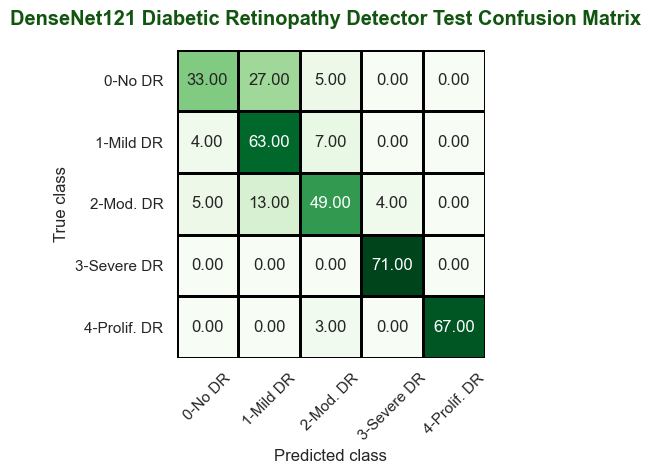

(70, 71, 70, 70, 70)

In [60]:
################################################################################################################################
# plot the confusion matrix of training and testing predictions and also print the traing classes counts 
################################################################################################################################
plt.figure(figsize=(4,4))
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
sns.heatmap(test_df_cm,annot=True,fmt='.2f',linewidths=2,linecolor='black',square=True,cmap=plt.cm.Greens,\
            cbar=False)
plt.suptitle('DenseNet121 Diabetic Retinopathy Detector Test Confusion Matrix',color='#115511',fontweight='bold')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()  
testDF.classes.count(0),testDF.classes.count(1),testDF.classes.count(2),testDF.classes.count(3),testDF.classes.count(4)

In [61]:
################################################################################################################################
# print the classification report giving precision, recall, f-1 score and accuracy of the pretrained DenseNet121 Model
################################################################################################################################
tnames=['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
print(classification_report(total_test_labels, total_test_preds,target_names=tnames))

                  precision    recall  f1-score   support

           No DR       0.79      0.51      0.62        65
         Mild DR       0.61      0.85      0.71        74
     Moderate DR       0.77      0.69      0.73        71
       Severe DR       0.95      1.00      0.97        71
Proliferative DR       1.00      0.96      0.98        70

        accuracy                           0.81       351
       macro avg       0.82      0.80      0.80       351
    weighted avg       0.82      0.81      0.80       351



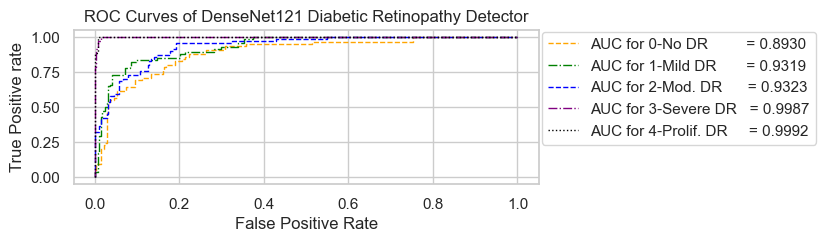

In [62]:
################################################################################################################################
# plot the roc_curve and print the AUC values in it for all the 5 classes of DenseNet121 Model.
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)

fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_classes = 5
i=0
while i < n_classes:
    fpr[i], tpr[i], thresh[i] = roc_curve(Test_Labels[:,i], Test_Pred[:,i])
    i+=1

i=0
while i < n_classes:
    roc_auc[i] = auc(fpr[i], tpr[i])
    i+=1

plt.figure(figsize=(6,2))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange',lw=1, label='AUC for 0-No DR         = %0.4f'% roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='-.',color='green', lw=1, label='AUC for 1-Mild DR       = %0.4f'% roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue',  lw=1, label='AUC for 2-Mod. DR      = %0.4f'% roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='-.',color='purple',lw=1, label='AUC for 3-Severe DR   = %0.4f'% roc_auc[3])
plt.plot(fpr[4], tpr[4], linestyle=':', color='black', lw=1, label='AUC for 4-Prolif. DR     = %0.4f'% roc_auc[4])


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curves of DenseNet121 Diabetic Retinopathy Detector') 
plt.grid(True)
plt.legend(loc='best', bbox_to_anchor=(0.99, .54, 0.5, 0.5))
plt.show()


In [63]:
print(accuracy_score(total_test_preds,total_test_labels))

0.8062678062678063


In [64]:
printmd('DenseNet121 Model has the accuracy of 77.49% ')

## <span style="color:#111155">DenseNet121 Model has the accuracy of 77.49% </span>

In [65]:
printmd('ResNet50V2 Model evaluation and prediction next')

## <span style="color:#111155">ResNet50V2 Model evaluation and prediction next</span>

In [66]:
################################################################################################################################
###############################  load the pretrained ResNet50V2 model              #############################################
################################################################################################################################

model = ResNet50V2(weights='imagenet',input_shape=(W,H,3),input_tensor=input_tensor,include_top=False)
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)  
x = Dropout(0.5)(x)
out = Dense(5,activation='softmax',activity_regularizer = tf.keras.regularizers.l2(0.000001))(x)
model = Model(input_tensor, out)
for layer in model.layers:
    layer.trainable = False

for i in range(-3, 0):
    model.layers[i].trainable = True



FILEPATHA="./Weights/weights_DRTD_ResNet50V2.h5"

model = load_model(FILEPATHA)
checkpointA = ModelCheckpoint(FILEPATHA, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callback_list = [tqdm_callback, checkpointA, Early_stop, Reduce_lr_on_plat]  
model.compile(optimizer=Adam(lr=0.0000002, beta_1=0.9), loss='categorical_crossentropy',  metrics=["accuracy"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 350, 350, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 356, 356, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 175, 175, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 177, 177, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [67]:
################################################################################################################################
# fit the ResNet50V2 model on just 5 epochs to show the training and testing accuracy and losses
################################################################################################################################
history = model.fit_generator(generator=trainDF,validation_data=testDF,epochs=5, callbacks=callback_list,verbose=0)

Training:   0%|                                                                                 0/5 ETA: ?s,  …

Epoch 1/5


0/131                                                                                                        E…


Epoch 00001: val_accuracy improved from -inf to 0.93162, saving model to ./Weights\weights_DRTD_ResNet50V2.h5
Epoch 2/5


0/131                                                                                                        E…


Epoch 00002: val_accuracy did not improve from 0.93162
Epoch 3/5


0/131                                                                                                        E…


Epoch 00003: val_accuracy did not improve from 0.93162
Epoch 4/5


0/131                                                                                                        E…


Epoch 00004: val_accuracy did not improve from 0.93162

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.900000022203585e-07.
Epoch 5/5


0/131                                                                                                        E…


Epoch 00005: val_accuracy did not improve from 0.93162


In [68]:
################################################################################################################################
# evaluate the ResNet50V2 Model on train and test datasets
################################################################################################################################
train_loss, train_acc = model.evaluate(trainDF, batch_size=8, verbose=0,callbacks=[tqdm_callback])
test_loss, test_acc = model.evaluate(testDF,  batch_size=8, verbose=0,callbacks=[tqdm_callback])
print('Train Accu: %.3f, Test Accu: %.3f' % (train_acc, test_acc))
print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss, test_loss))

0/131                                                                                              ETA: ?s - E…

0/44                                                                                               ETA: ?s - E…

Train Accu: 0.914, Test Accu: 0.932
Train Loss: 0.297, Test Loss: 0.264


In [69]:
################################################################################################################################
# predict using the model on training and testing data files, and compute data for confusion matix, class. report and AUC/ROC
################################################################################################################################
Test_size = testDF.n//testDF.batch_size
# Create empty arays to keep the predictions and labels
Test_Pred = np.empty((0, Classes))
Test_Labels = np.empty((0, Classes))

# Add test predictions and labels
for i in range(Test_size+1):
    image, label = next(testDF)
    scores = model.predict(image, batch_size=testDF.batch_size)
    Test_Pred = np.append(Test_Pred, scores, axis=0)
    Test_Labels = np.append(Test_Labels, label, axis=0)

total_test_preds  = [np.argmax(pred)  for pred  in Test_Pred]
total_test_labels = [np.argmax(label) for label in Test_Labels]
test_cnfu_matrix = confusion_matrix(total_test_labels, total_test_preds)
labels = ['0-No DR', '1-Mild DR', '2-Mod. DR', '3-Severe DR', '4-Prolif. DR']
test_df_cm  = pd.DataFrame(test_cnfu_matrix,  index=labels, columns=labels)
print(test_df_cm)

              0-No DR  1-Mild DR  2-Mod. DR  3-Severe DR  4-Prolif. DR
0-No DR            60          3          4            0             0
1-Mild DR           1         69          3            0             0
2-Mod. DR           9          4         57            2             0
3-Severe DR         0          0          0           69             0
4-Prolif. DR        0          0          0            0            70


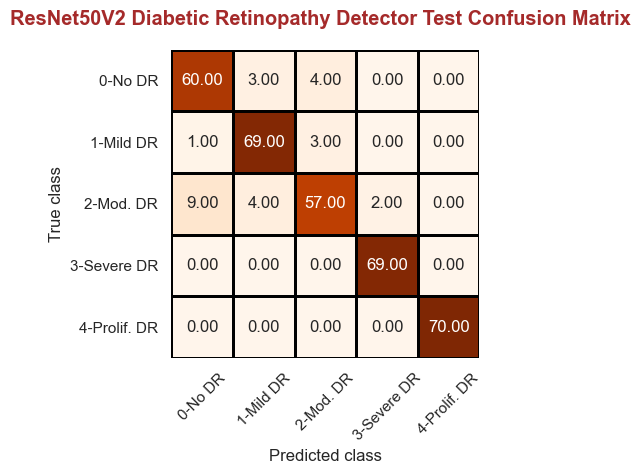

(70, 71, 70, 70, 70)

In [70]:
################################################################################################################################
# plot the confusion matrix of training and testing predictions and also print the traing classes counts 
################################################################################################################################
plt.figure(figsize=(4,4))
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
sns.heatmap(test_df_cm,annot=True,fmt='.2f',linewidths=2,linecolor='black',square=True,cmap=plt.cm.Oranges,\
            cbar=False)
plt.suptitle('ResNet50V2 Diabetic Retinopathy Detector Test Confusion Matrix',color='brown',fontweight='bold')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()  
testDF.classes.count(0),testDF.classes.count(1),testDF.classes.count(2),testDF.classes.count(3),testDF.classes.count(4)

In [71]:
################################################################################################################################
# print the classification report giving precision, recall, f-1 score and accuracy of the pretrained ResNet50V2 Model
################################################################################################################################
tnames=['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
print(classification_report(total_test_labels, total_test_preds,target_names=tnames))

                  precision    recall  f1-score   support

           No DR       0.86      0.90      0.88        67
         Mild DR       0.91      0.95      0.93        73
     Moderate DR       0.89      0.79      0.84        72
       Severe DR       0.97      1.00      0.99        69
Proliferative DR       1.00      1.00      1.00        70

        accuracy                           0.93       351
       macro avg       0.93      0.93      0.93       351
    weighted avg       0.93      0.93      0.92       351



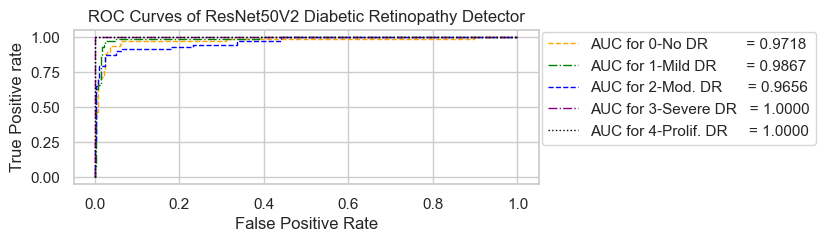

In [72]:
################################################################################################################################
# plot the ROC/AUC Curve for ResNet50v2 model and also print the AUC values for all classes
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_classes = 5
i=0
while i < n_classes:
    fpr[i], tpr[i], thresh[i] = roc_curve(Test_Labels[:,i], Test_Pred[:,i])
    i+=1

i=0
while i < n_classes:
    roc_auc[i] = auc(fpr[i], tpr[i])
    i+=1

plt.figure(figsize=(6,2))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange',lw=1, label='AUC for 0-No DR         = %0.4f'% roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='-.',color='green', lw=1, label='AUC for 1-Mild DR       = %0.4f'% roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue',  lw=1, label='AUC for 2-Mod. DR      = %0.4f'% roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='-.',color='purple',lw=1, label='AUC for 3-Severe DR   = %0.4f'% roc_auc[3])
plt.plot(fpr[4], tpr[4], linestyle=':', color='black', lw=1, label='AUC for 4-Prolif. DR     = %0.4f'% roc_auc[4])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curves of ResNet50V2 Diabetic Retinopathy Detector') 
plt.grid(True)
plt.legend(loc='best', bbox_to_anchor=(0.99, .54, 0.5, 0.5))
plt.show()


In [73]:
print(accuracy_score(total_test_preds,total_test_labels))

0.9259259259259259


In [90]:
printmd('ResNet50V2 has the accuracy rate of 93.16 %')

## <span style="color:#111155">ResNet50V2 has the accuracy rate of 93.16 %</span>

In [75]:
printmd('Xception Model evaluation and prediction is next ')

## <span style="color:#111155">Xception Model evaluation and prediction is next </span>

In [76]:
################################################################################################################################
###############################  load the pretrained Xception model                #############################################
################################################################################################################################

model = Xception(weights='imagenet',input_shape=(W,H,3),input_tensor=input_tensor,include_top=False)
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation='relu')(x)  
x = Dropout(0.5)(x)
out = Dense(5,activation='softmax',activity_regularizer = tf.keras.regularizers.l2(0.000001))(x)
model = Model(input_tensor, out)
for layer in model.layers:
    layer.trainable = False

for i in range(-3, 0):
    model.layers[i].trainable = True



FILEPATHA="./Weights/weights_DRTD_Xception.hdf5"

 

model = load_model(FILEPATHA)
checkpointA = ModelCheckpoint(FILEPATHA, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callback_list = [tqdm_callback, checkpointA, Early_stop, Reduce_lr_on_plat]  
model.compile(optimizer=Adam(lr=0.0000002, beta_1=0.9), loss='categorical_crossentropy',  metrics=["accuracy"])
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 350, 350, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 174, 174, 32) 864         input_21[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 174, 174, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 174, 174, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [77]:
################################################################################################################################
# fit the Xception model on just 5 epochs to show the training and testing accuracy and losses
################################################################################################################################
history = model.fit_generator(generator=trainDF,validation_data=testDF,epochs=5, callbacks=callback_list,verbose=0)

Training:   0%|                                                                                 0/5 ETA: ?s,  …

Epoch 1/5


0/131                                                                                                        E…


Epoch 00001: val_accuracy improved from -inf to 0.84900, saving model to ./Weights\weights_DRTD_Xception.hdf5
Epoch 2/5


0/131                                                                                                        E…


Epoch 00002: val_accuracy did not improve from 0.84900
Epoch 3/5


0/131                                                                                                        E…


Epoch 00003: val_accuracy did not improve from 0.84900
Epoch 4/5


0/131                                                                                                        E…


Epoch 00004: val_accuracy did not improve from 0.84900

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.900000022203585e-07.
Epoch 5/5


0/131                                                                                                        E…


Epoch 00005: val_accuracy did not improve from 0.84900


In [78]:
################################################################################################################################
# evaluate the Xception Model on train and test datasets
################################################################################################################################
train_loss, train_acc = model.evaluate(trainDF, batch_size=8, verbose=0,callbacks=[tqdm_callback])
test_loss, test_acc = model.evaluate(testDF,  batch_size=8, verbose=0,callbacks=[tqdm_callback])
print('Train Accu: %.3f, Test Accu: %.3f' % (train_acc, test_acc))
print('Train Loss: %.3f, Test Loss: %.3f' % (train_loss, test_loss))

0/131                                                                                              ETA: ?s - E…

0/44                                                                                               ETA: ?s - E…

Train Accu: 0.837, Test Accu: 0.846
Train Loss: 0.444, Test Loss: 0.418


In [79]:
################################################################################################################################
# predict using the model on training and testing data files, and compute data for confusion matix, class. report and AUC/ROC
################################################################################################################################
Test_size = testDF.n//testDF.batch_size
# Create empty arays to keep the predictions and labels
Test_Pred = np.empty((0, Classes))
Test_Labels = np.empty((0, Classes))

# Add test predictions and labels
for i in range(Test_size+1):
    image, label = next(testDF)
    scores = model.predict(image, batch_size=testDF.batch_size)
    Test_Pred = np.append(Test_Pred, scores, axis=0)
    Test_Labels = np.append(Test_Labels, label, axis=0)

total_test_preds  = [np.argmax(pred)  for pred  in Test_Pred]
total_test_labels = [np.argmax(label) for label in Test_Labels]
test_cnfu_matrix = confusion_matrix(total_test_labels, total_test_preds)
labels = ['0-No DR', '1-Mild DR', '2-Mod. DR', '3-Severe DR', '4-Prolif. DR']
test_df_cm  = pd.DataFrame(test_cnfu_matrix,  index=labels, columns=labels)
print(test_df_cm)

              0-No DR  1-Mild DR  2-Mod. DR  3-Severe DR  4-Prolif. DR
0-No DR            55         14          2            0             0
1-Mild DR          10         56          5            0             0
2-Mod. DR          12         11         51            1             2
3-Severe DR         0          0          1           61             0
4-Prolif. DR        0          0          0            0            70


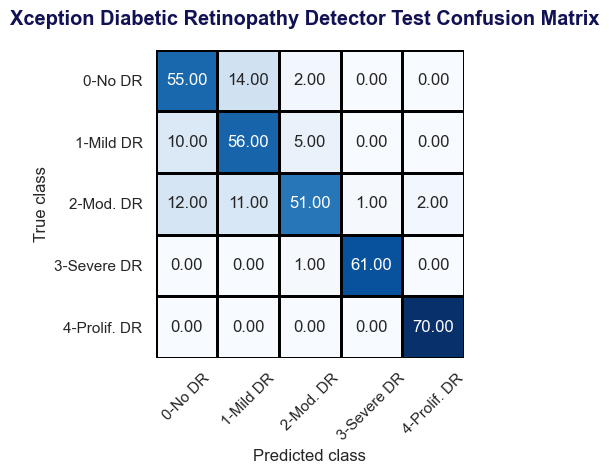

(70, 71, 70, 70, 70)

In [80]:
################################################################################################################################
# plot the confusion matrix of training and testing predictions and also print the traing classes counts 
################################################################################################################################
plt.figure(figsize=(4,4))
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
sns.heatmap(test_df_cm,annot=True,fmt='.2f',linewidths=2,linecolor='black',square=True,cmap=plt.cm.Blues,\
            cbar=False)
plt.suptitle('Xception Diabetic Retinopathy Detector Test Confusion Matrix',color='#111155',fontweight='bold')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()  
testDF.classes.count(0),testDF.classes.count(1),testDF.classes.count(2),testDF.classes.count(3),testDF.classes.count(4)

In [81]:
################################################################################################################################
# print the classification report giving precision, recall, f-1 score and accuracy of the pretrained xception model
################################################################################################################################
tnames=['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']
print(classification_report(total_test_labels, total_test_preds,target_names=tnames))

                  precision    recall  f1-score   support

           No DR       0.71      0.77      0.74        71
         Mild DR       0.69      0.79      0.74        71
     Moderate DR       0.86      0.66      0.75        77
       Severe DR       0.98      0.98      0.98        62
Proliferative DR       0.97      1.00      0.99        70

        accuracy                           0.83       351
       macro avg       0.85      0.84      0.84       351
    weighted avg       0.84      0.83      0.83       351



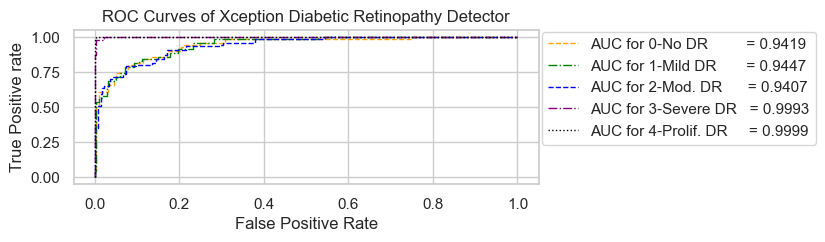

In [82]:
################################################################################################################################
# plot the ROC AUC Curve of the xception pretrained model and display the AUC values for all classes.
################################################################################################################################
sns.set(style='whitegrid', palette='muted', font_scale=1.0)
fpr = {}
tpr = {}
thresh = {}
roc_auc = {}

n_classes = 5
i=0
while i < n_classes:
    fpr[i], tpr[i], thresh[i] = roc_curve(Test_Labels[:,i], Test_Pred[:,i])
    i+=1

i=0
while i < n_classes:
    roc_auc[i] = auc(fpr[i], tpr[i])
    i+=1

plt.figure(figsize=(6,2))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange',lw=1, label='AUC for 0-No DR         = %0.4f'% roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='-.',color='green', lw=1, label='AUC for 1-Mild DR       = %0.4f'% roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue',  lw=1, label='AUC for 2-Mod. DR      = %0.4f'% roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='-.',color='purple',lw=1, label='AUC for 3-Severe DR   = %0.4f'% roc_auc[3])
plt.plot(fpr[4], tpr[4], linestyle=':', color='black', lw=1, label='AUC for 4-Prolif. DR     = %0.4f'% roc_auc[4])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.title('ROC Curves of Xception Diabetic Retinopathy Detector') 
plt.grid(True)
plt.legend(loc='best', bbox_to_anchor=(0.99, .54, 0.5, 0.5))
plt.show()


In [83]:
print(accuracy_score(total_test_preds,total_test_labels))

0.8347578347578347


In [88]:
printmd('Xception Diabetic Retinopathy Detector model has the accuracy rate of 83.47 %')

## <span style="color:#111155">Xception Diabetic Retinopathy Detector model has the accuracy rate of 83.47 %</span>

In [85]:
print ('Job Execution time in hours : ', (time.time() - start)/3600)

Job Execution time in hours :  1.9601213570435843


In [91]:
printmd('Summary of all models:')
printmd('Self Designed Model accuracy-----------: 92.30%')
printmd('InceptionResNetv2 Model accuracy----: 88.90%')
printmd('DenseNet121 Model accuracy------------: 79.20%')
printmd('ResNet50V2 Model accuracy-------------: 93.16%')
printmd('Xception Model accuracy------------------: 83.47%')

printmd('Out of the 5 models, self designed model has the best accuracy with less than a million parameters!')

## <span style="color:#111155">Summary of all models:</span>

## <span style="color:#111155">Self Designed Model accuracy-----------: 92.30%</span>

## <span style="color:#111155">InceptionResNetv2 Model accuracy----: 88.90%</span>

## <span style="color:#111155">DenseNet121 Model accuracy------------: 79.20%</span>

## <span style="color:#111155">ResNet50V2 Model accuracy-------------: 93.16%</span>

## <span style="color:#111155">Xception Model accuracy------------------: 83.47%</span>

## <span style="color:#111155">Out of the 5 models, self designed model has the best accuracy with less than a million parameters!</span>